# Deep Learning with PyTorch : Build a Generative Adversarial Network 

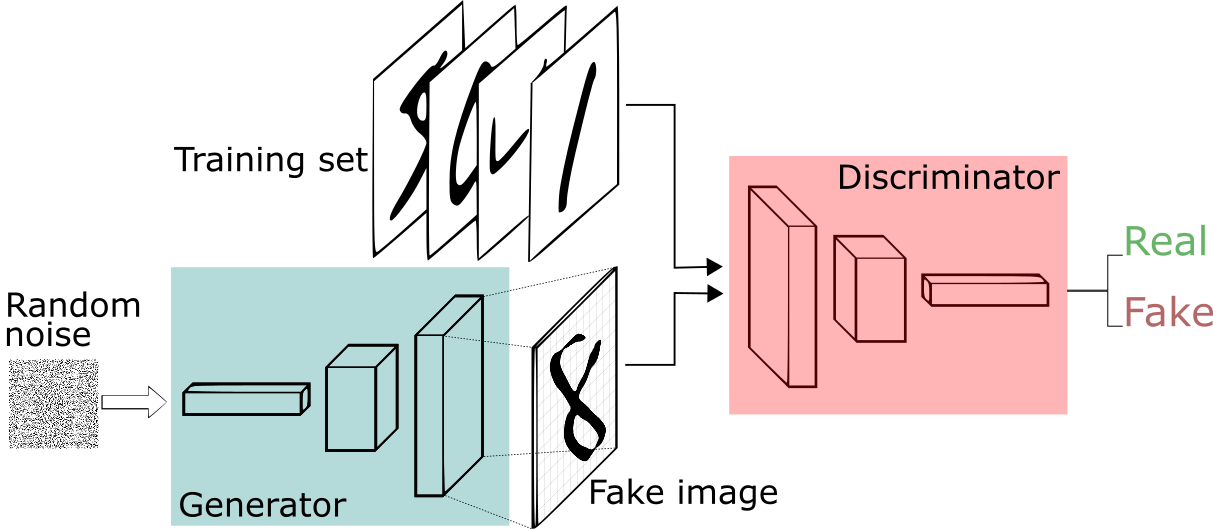

In [1]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

# Configurations

In [2]:
# using GPU
device = 'cuda'
batch_size = 128
noise_vec_dim = 64 # shape of random noise vector

#optimizer params
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# training variables
epochs = 20

# Load MNIST Dataset 

In [3]:
from torchvision import datasets, transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # converts the PIL images into torch tensor
    # this also shifts the channel to the 0th axis (h, w, c) -> (c, h, w)
])

In [5]:
train_set = datasets.MNIST('MNIST/', download=True, train = True, transform = train_augs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



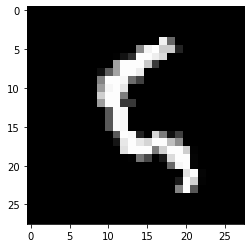

In [9]:
image, _ = train_set[100]

plt.imshow(image.squeeze(), cmap = 'gray')

In [10]:
# total images in trainset
len(train_set)

60000

# Load Dataset Into Batches 

In [11]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [12]:
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

In [13]:
# number of batches in train loader
len(trainloader)

469

In [16]:
data_iter = iter(trainloader)

images, _ = next(data_iter)

# size of each batch
images.shape

torch.Size([128, 1, 28, 28])

In [17]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

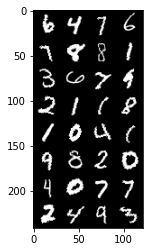

In [18]:
show_tensor_images(images, num_images = 32)

# Create Discriminator Network 

In [ ]:
#In case if torch summary is not installed 

!pip install torchsummary

In [19]:
from torch import nn
from torchsummary import summary

In [ ]:
# A discriminator is a simple binary classifier which classifies wheather an image is a real image or a fake image

'''

Network : Discriminator

input : (batch_size, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [20]:
def get_discriminator_block(in_channel, out_channel, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size, stride),
      nn.BatchNorm2d(out_channel),
      nn.LeakyReLU(0.2)
  )

In [21]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_discriminator_block(1, 16, (3, 3), 2)
    self.block_2 = get_discriminator_block(16, 32, (5, 5), 2)
    self.block_3 = get_discriminator_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)
  
  def forward(self, images):
    b1 = self.block_1(images)
    b2 = self.block_2(b1)
    b3 = self.block_3(b2)
    flatten = self.flatten(b3)
    probs = self.linear(flatten)
    # we are not using sigmoid layer

    return probs

In [37]:
discr_model = Discriminator()
discr_model.to(device)

summary(discr_model, input_size = (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba


# Create Generator Network 

In [ ]:
# A generator network generates realistic fake images with the given random noise

'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

In [29]:
def get_generator_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block:
    return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [32]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim

    self.block_1 = get_generator_block(noise_vec_dim, 256, (3, 3), 2)
    self.block_2 = get_generator_block(256, 128, (4, 4), 1)
    self.block_3 = get_generator_block(128, 64, (3, 3), 2)
    self.block_4 = get_generator_block(64, 1, (4, 4), 2, final_block=True)
  
  def forward(self, random_noise_vec):
    # change the random noise vector shape from (batch_size, noise_dim) -> (batch_size, noise_dim, 1, 1)

    noise_vec = random_noise_vec.view(-1, self.noise_dim, 1, 1)

    b1 = self.block_1(noise_vec)
    b2 = self.block_2(b1)
    b3 = self.block_3(b2)
    b4 = self.block_4(b3)

    return b4

In [35]:
gen_model = Generator(noise_dim = noise_vec_dim)
gen_model.to(device)

summary(gen_model, input_size = (1, noise_vec_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [36]:
# Replace Random initialized weights to Normal weights for robust training

def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [38]:
discr_model.apply(weights_init)
gen_model.apply(weights_init)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [39]:
def real_loss(disc_pred):
  ground_truth = torch.ones_like(disc_pred)

  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, ground_truth)

  return loss

In [40]:
def fake_loss(disc_pred):
  ground_truth = torch.zeros_like(disc_pred)

  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(disc_pred, ground_truth)

  return loss

In [42]:
disc_opt = torch.optim.Adam(discr_model.parameters(), lr = lr, betas = (beta_1, beta_2))
gen_opt = torch.optim.Adam(gen_model.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop 

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 1 | discr_loss : 0.6854432433652979 | gen_loss: 0.6810965109735664


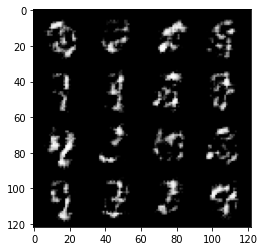

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 2 | discr_loss : 0.6806919141364759 | gen_loss: 0.7096712964175861


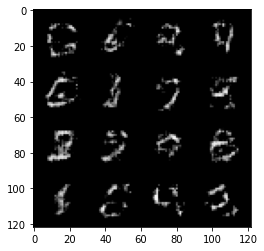

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 3 | discr_loss : 0.6509470055098219 | gen_loss: 0.746149287676252


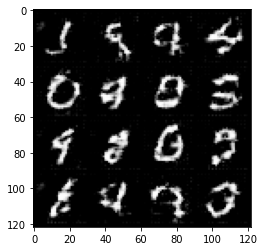

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 4 | discr_loss : 0.6279989337361952 | gen_loss: 0.7805348890168327


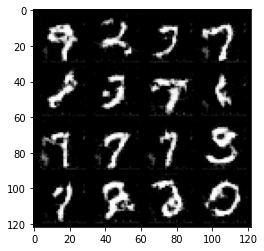

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 5 | discr_loss : 0.6193820532959408 | gen_loss: 0.8043419468377445


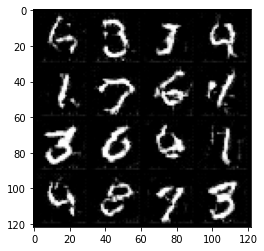

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 6 | discr_loss : 0.6197928960389419 | gen_loss: 0.8183997489496081


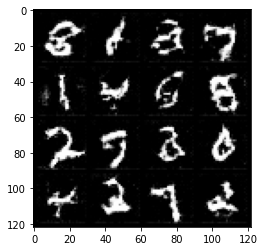

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 7 | discr_loss : 0.6258030123293781 | gen_loss: 0.8232166889125604


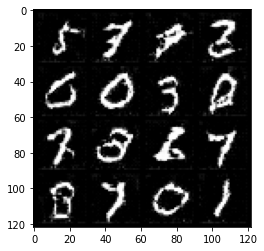

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 8 | discr_loss : 0.631742301017745 | gen_loss: 0.8235614848797763


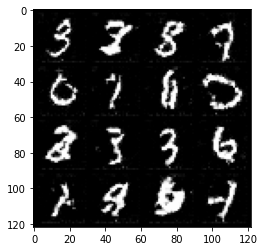

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 9 | discr_loss : 0.6347838768572696 | gen_loss: 0.8272186892627399


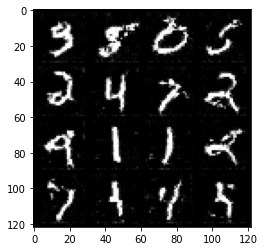

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 10 | discr_loss : 0.637890031724088 | gen_loss: 0.8248023469565011


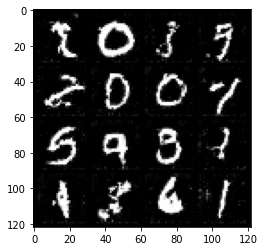

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 11 | discr_loss : 0.6416014486284398 | gen_loss: 0.8249126234288409


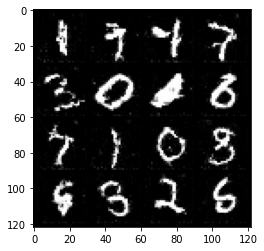

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 12 | discr_loss : 0.6430886924139726 | gen_loss: 0.8253193598057924


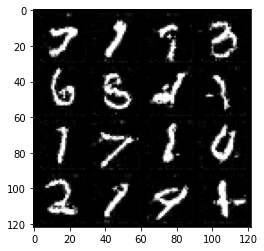

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 13 | discr_loss : 0.6447963592594367 | gen_loss: 0.8247329813839276


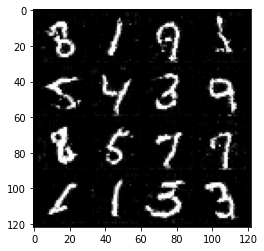

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 14 | discr_loss : 0.6448762866733934 | gen_loss: 0.8271440112514536


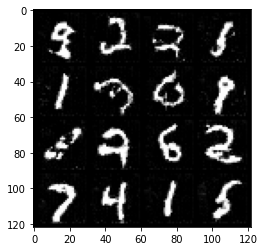

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 15 | discr_loss : 0.6447994689951574 | gen_loss: 0.8273235304015023


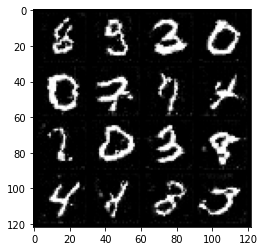

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 16 | discr_loss : 0.6470420144514234 | gen_loss: 0.8265669696620787


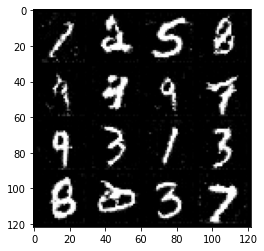

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 17 | discr_loss : 0.6463786084006335 | gen_loss: 0.8294413080855981


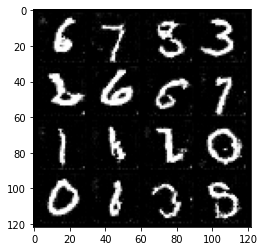

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 18 | discr_loss : 0.6473911926944627 | gen_loss: 0.8293326150125532


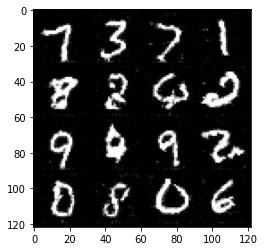

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 19 | discr_loss : 0.6470856001890545 | gen_loss: 0.8310964812856239


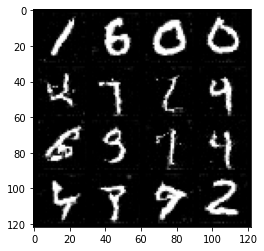

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 20 | discr_loss : 0.6469830556719034 | gen_loss: 0.8329415287036123


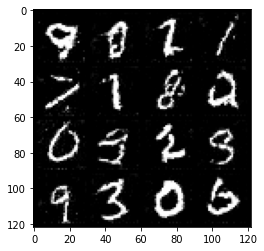

In [43]:
for i in range(epochs):

  total_disc_loss = 0.0
  total_gen_loss = 0.0

  for real_img, _ in tqdm(trainloader):

    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_vec_dim, device = device)

    # find the loss and update the weights for the discriminator network

    # ensure 0 gradients
    disc_opt.zero_grad()

    # generate fake imgs
    fake_img = gen_model(noise)
    
    disc_pred = discr_model(fake_img)
    disc_fake_loss = fake_loss(disc_pred)
    
    disc_pred = discr_model(real_img)
    disc_real_loss = real_loss(disc_pred)

    # average of the losses
    discr_loss = (disc_fake_loss + disc_real_loss) / 2

    total_disc_loss += discr_loss.item()

    # gradients
    discr_loss.backward()

    # update the weights of the discriminator network
    disc_opt.step()


    # find the loss and update the weights for the generator network

    gen_opt.zero_grad()

    # generate fake img
    fake_img = gen_model(noise)

    disc_pred = discr_model(fake_img)
    
    gen_loss = real_loss(disc_pred)

    total_gen_loss += gen_loss.item()

    gen_loss.backward()

    gen_opt.step()



  avg_disc_loss = total_disc_loss / len(trainloader)
  avg_gen_loss = total_gen_loss / len(trainloader)

  print(f'Epoch: {i+1} | discr_loss : {avg_disc_loss} | gen_loss: {avg_gen_loss}')

  show_tensor_images(fake_img)

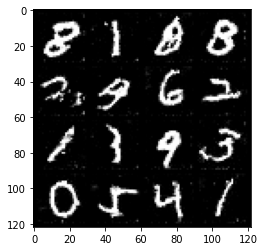

In [44]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_vec_dim, device = device)
generated_image = gen_model(noise)

show_tensor_images(generated_image)

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya